In [34]:
#Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.signal import savgol_filter

#Suavización Exponencial
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#Sarimax
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


In [35]:
confirmed_df = pd.read_csv('data/time_series_covid19_confirmed_global.csv')
confirmed_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,1/29/23,1/30/23,1/31/23,2/1/23,2/2/23,2/3/23,2/4/23,2/5/23,2/6/23,2/7/23,2/8/23,2/9/23,2/10/23,2/11/23,2/12/23,2/13/23,2/14/23,2/15/23,2/16/23,2/17/23,2/18/23,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,...,208435,208502,208545,208552,208669,208669,208621,208627,208704,208721,208771,208771,208943,208971,208982,209011,209036,209056,209072,209083,209084,209107,209153,209181,209181,209215,209230,209246,209274,209308,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,334157,334157,334167,334177,334187,334203,334204,334211,334211,334211,334222,334229,334229,334234,334255,334255,334264,334264,334273,334291,334305,334314,334315,334336,334336,334345,334356,334373,334378,334380,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,271376,271376,271378,271385,271386,271394,271394,271394,271395,271399,271403,271406,271406,271409,271409,271409,271409,271421,271424,271424,271425,271425,271426,271428,271431,271432,271436,271439,271440,271440,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47839,47839,47839,47839,47839,47850,47850,47850,47850,47850,47850,47860,47860,47860,47860,47860,47860,47860,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105205,105205,105205,105205,105205,105255,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [36]:
deaths_df= pd.read_csv('data/time_series_covid19_deaths_global.csv')
cols = deaths_df.columns
deaths_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,1/29/23,1/30/23,1/31/23,2/1/23,2/2/23,2/3/23,2/4/23,2/5/23,2/6/23,2/7/23,2/8/23,2/9/23,2/10/23,2/11/23,2/12/23,2/13/23,2/14/23,2/15/23,2/16/23,2/17/23,2/18/23,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7876,7879,7882,7882,7891,7891,7894,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933


In [37]:
confirmed = confirmed_df.loc[:, cols[4]:cols[-1]]
confirmed.head()


,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,1/29/23,1/30/23,1/31/23,2/1/23,2/2/23,2/3/23,2/4/23,2/5/23,2/6/23,2/7/23,2/8/23,2/9/23,2/10/23,2/11/23,2/12/23,2/13/23,2/14/23,2/15/23,2/16/23,2/17/23,2/18/23,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,5,5,5,5,...,208435,208502,208545,208552,208669,208669,208621,208627,208704,208721,208771,208771,208943,208971,208982,209011,209036,209056,209072,209083,209084,209107,209153,209181,209181,209215,209230,209246,209274,209308,209322,209340,209358,209362,209369,209390,209406,209436,209451,209451
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,334157,334157,334167,334177,334187,334203,334204,334211,334211,334211,334222,334229,334229,334234,334255,334255,334264,334264,334273,334291,334305,334314,334315,334336,334336,334345,334356,334373,334378,334380,334391,334408,334408,334427,334427,334427,334427,334427,334443,334457
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,...,271376,271376,271378,271385,271386,271394,271394,271394,271395,271399,271403,271406,271406,271409,271409,271409,271409,271421,271424,271424,271425,271425,271426,271428,271431,271432,271436,271439,271440,271440,271441,271448,271463,271469,271469,271477,271477,271490,271494,271496
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,47839,47839,47839,47839,47839,47850,47850,47850,47850,47850,47850,47860,47860,47860,47860,47860,47860,47860,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47866,47875,47875,47875,47875,47875,47875,47875,47890,47890
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105184,105205,105205,105205,105205,105205,105255,105255,105277,105277,105277,105277,105277,105277,105277,105288,105288


In [38]:
deaths = deaths_df.loc[:, cols[4]:cols[-1]]
deaths.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,...,1/29/23,1/30/23,1/31/23,2/1/23,2/2/23,2/3/23,2/4/23,2/5/23,2/6/23,2/7/23,2/8/23,2/9/23,2/10/23,2/11/23,2/12/23,2/13/23,2/14/23,2/15/23,2/16/23,2/17/23,2/18/23,2/19/23,2/20/23,2/21/23,2/22/23,2/23/23,2/24/23,2/25/23,2/26/23,2/27/23,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7876,7879,7882,7882,7891,7891,7894,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3596,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598,3598
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881,6881
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165,165
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1931,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933,1933


In [39]:
dates = confirmed.keys()
dates

Index(['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20',
       '1/28/20', '1/29/20', '1/30/20', '1/31/20',
       ...
       '2/28/23', '3/1/23', '3/2/23', '3/3/23', '3/4/23', '3/5/23', '3/6/23',
       '3/7/23', '3/8/23', '3/9/23'],
      dtype='object', length=1143)

In [45]:
# Creación de las series de tiempo
world_cases = []
total_deaths = []
mortality_rate = []

for i in dates:
    confirmed_sum = confirmed[i].sum()
    death_sum = deaths[i].sum()
    world_cases.append(confirmed_sum)
    total_deaths.append(death_sum)
    mortality_rate.append(death_sum/confirmed_sum)

world_cases_df = pd.DataFrame([dates, world_cases])
world_cases_df = world_cases_df.transpose()
world_cases_df.columns = ['dates', 'cases']

total_deaths_df = pd.DataFrame([dates, total_deaths])
total_deaths_df = total_deaths_df.transpose()
total_deaths_df.columns = ['dates', 'deaths']

mortality_rate_df = pd.DataFrame([dates, mortality_rate])
mortality_rate_df = mortality_rate_df.transpose()
mortality_rate_df.columns = ['dates', 'mortality rate']

In [46]:
world_cases_df.head()

,dates,cases
0,1/22/20,557
1,1/23/20,657
2,1/24/20,944
3,1/25/20,1437
4,1/26/20,2120


#### Gráficos de Las Series

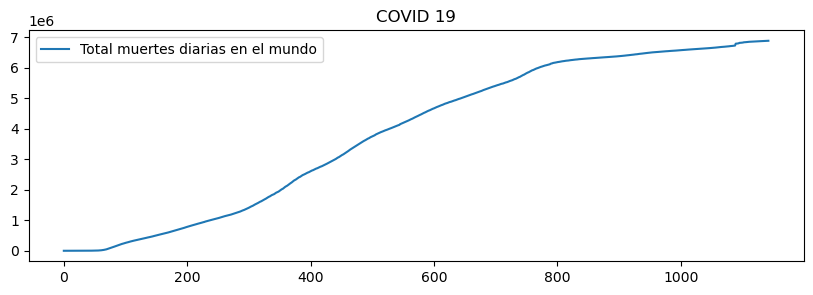

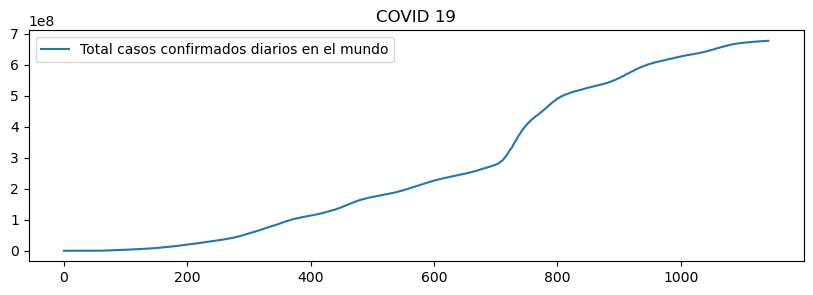

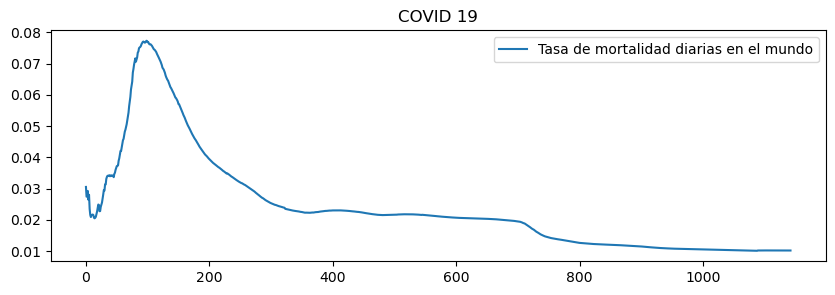

In [47]:
plt.figure(figsize=(10,3))
plt.plot(total_deaths_df.deaths, label = 'Total muertes diarias en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(world_cases_df.cases, label = 'Total casos confirmados diarios en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(mortality_rate_df['mortality rate'], label = 'Tasa de mortalidad diarias en el mundo')
plt.title('COVID 19')
plt.legend()
plt.show()

#### Función para calcular los incrementos diarios

In [48]:
def daily_increase(data):
    d = []
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i] - data[i-1])
    return d

#### Función de filtrado

In [49]:
def maFilter(x, N):
    xTemp = np.zeros(len(x) + (N - 1))
    xTemp[(N - 1):] = x
    y = np.zeros(len(x))

    for i in range(0, len(x)):
        y[i] = xTemp[i : i + N].sum()/float(N)
    return y

In [52]:
window = 7

#Casos
world_daily_increase = daily_increase(world_cases_df.cases)
world_daily_increase_avg = maFilter(world_daily_increase, window)

#Muertes
world_daily_deaths = daily_increase(total_deaths_df.deaths)
world_daily_deaths_avg = maFilter(world_daily_deaths, window)

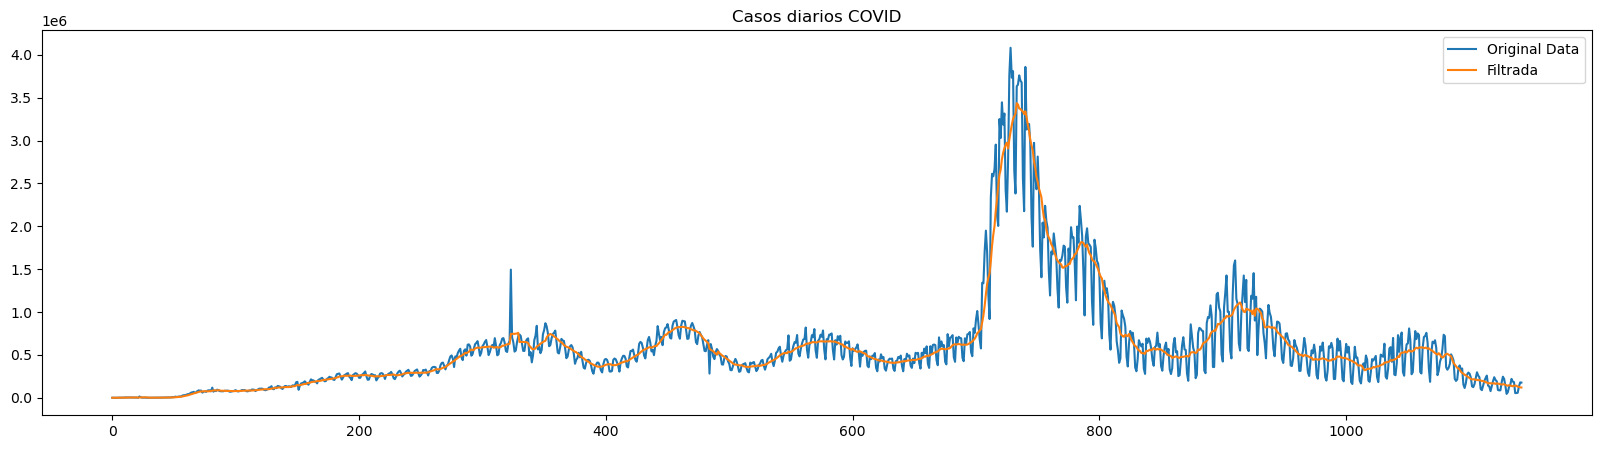

In [54]:
plt.figure(figsize=(20,5))
plt.plot(world_daily_increase, label='Original Data')
plt.plot(world_daily_increase_avg, label= 'Filtrada')
plt.title('Casos diarios COVID')
plt.legend()
plt.show()

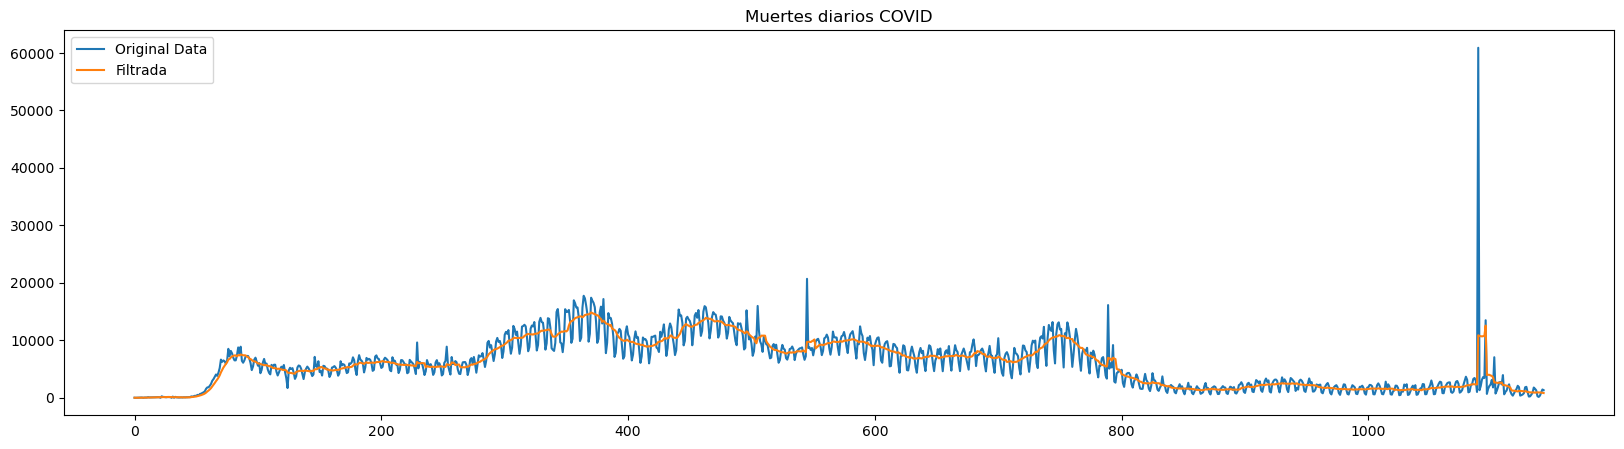

In [55]:
plt.figure(figsize=(20,5))
plt.plot(world_daily_deaths, label='Original Data')
plt.plot(world_daily_deaths_avg, label= 'Filtrada')
plt.title('Muertes diarios COVID')
plt.legend()
plt.show()

# Modelos para Trabajar con Series de Tiempo

## Suavización Exponencial Simple

Supone que el valor siguiente de una serie depende exclusivamente de su valor pasado

In [80]:
world_deaths_increase_df = pd.DataFrame({'Date':np.array(dates), 'deaths': np.array(world_daily_deaths)})
world_deaths_increase_df.describe()


,deaths
count,1143.000000
mean,6020.824147
std,4451.940318
min,1.000000
25%,2177.000000
50%,5839.000000
75%,8773.000000
max,60903.000000


In [84]:
world_deaths_increase_df[world_deaths_increase_df['deaths'] == world_deaths_increase_df['deaths'].max()]

,Date,deaths
1089,1/15/23,60903



## Suavización Exponencial Holt Winters

Incluye la tendencia a la suavización exponencial. Depende de su valor previo y la tendencia que marca el comportamiento de la serie